In [1]:
import numpy as np
import pandas as pd
import os
import glob
import sys
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colors
import cartopy.crs as ccrs  # Import cartopy ccrs
import cartopy.feature as cfeature  # Import cartopy common features
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

sys.path.insert(0, "/home/chalifour/code/master")
from matplotlib.patches import Patch

try:
    import rpnpy.librmn.all as rmn  # Module to read RPN files
    from rotated_lat_lon import RotatedLatLon  # Module to project field on native grid (created by Sasha Huziy)
except ImportError as err:
    print(f"RPNPY can only be use on the server. It can't be use on a personal computer."
          f"\nError throw :{err}")


In [2]:
lat_qc = 46.820634
lon_qc = -71.232010
lat_momo = 47.322437368331876
lon_momo = -71.14730110000002


# station radiosondage
# maniwaki,sept-ile,
lat_sond = [46.3019, 50.2233]
lon_sond = [-76.0061, -66.2656]


name = ['Gault', 'Arboretum', 'PK-UQAM',]
list_stat_lon = [-73.149006, -73.942156, -73.568741]
list_stat_lat = [45.535021, 45.430065, 45.508594]

name = ['PK-UQAM',]
list_stat_lon = [-73.568741]
list_stat_lat = [45.508594]
# stattin HQ

df_disdro = pd.read_csv('/upslope/chalifour/code_fig_bassin_domaine/Disdrometres_coordonnées.csv',header=0)
df_hq = pd.read_csv('/upslope/chalifour/code_fig_bassin_domaine/stat_retra.csv',delimiter=';',header=0)


In [3]:



# Example parameters which need to get adjusted !!!
# ================================================
filename = '/chinook/roberge/Output/GEM5/Cascades_CORDEX/CLASS/Safe_versions/Spinup/NAM-11m_ERA5_GEM5_CLASS_NV_NA_newP3-SCPF_SN8_20yrs/Samples/NAM-11m_ERA5_GEM5_CLASS_NV_NA_newP3-SCPF_SN8_20yrs_201501'  # Name of RPN file to read
varname = 'TT'  # Name of variable to read

title    = 'Domaines'
#unit     = r"${\rm ^\circ C}$"     # r + symbol of the unit of the values ("m", "%", "${\rm ^\circ C}$", "m/s", "${\rm W/m^2}$", ...)
#val_min  =  -4
#val_max  =  18
#val_int  =   2
# Output image information
image_output_file = "/upslope/chalifour/projet_maitrise/figure_final_submission"
image_output_dpi = 150
# ================================================



# Read one record
# ---------------
fid = rmn.fstopenall(filename,rmn.FST_RO)   # Open the file
rec = rmn.fstlir(fid,nomvar=varname)        # Read the full record of variable 'varname'
field = rec['d']                            # Assign 'field' to the data of 'varname'


# Read 2-D latitudes & longitudes - if needed
mygrid = rmn.readGrid(fid,rec)              # Get the grid information for the (LAM) Grid -- Reads the tictac's
latlondict = rmn.gdll(mygrid)               # Create 2-D lat and lon fields from the grid information
lat_12km = latlondict['lat']                     # Assign 'lat' to 2-D latitude field
lon_12km = latlondict['lon']     # Assign 'lon' to 2-D longitude field

# Creer le rectangle
segSlon_12km = lon_12km[ :,0]  ; segSlat_12km = lat_12km[ :,0]  ; #segment sud   du domaine
segWlon_12km = lon_12km[-1,:]  ; segWlat_12km = lat_12km[-1,:]  ; #segment ouest du domaine
segNlon_12km = np.flip(lon_12km[:,-1]); segNlat_12km = np.flip(lat_12km[:,-1]); #segment nord  du domaine
segElon_12km = np.flip(lon_12km[ 0,:]); segElat_12km = np.flip(lat_12km[ 0,:]); #segment est  du domaine

rect12kmlon = np.concatenate((segSlon_12km, segWlon_12km, segNlon_12km, segElon_12km))
rect12kmlat = np.concatenate((segSlat_12km, segWlat_12km, segNlat_12km, segElat_12km))


# Get grid rotation for projection of 2-D field for mapping - if needed
tics = rmn.fstlir(fid,nomvar='^^', ip1=rec['ig1'],ip2=rec['ig2'],ip3=rec['ig3']) # Read corresponding tictac's

# Close RPN input file
rmn.fstcloseall(fid)                        # Close the RPN file

# 2-D Mapping - if needed
# -----------------------
# Get positions of rotated equator from IG1-4 of the tictac's
(Grd_xlat1,Grd_xlon1,Grd_xlat2,Grd_xlon2) = rmn.cigaxg('E', tics['ig1'],tics['ig2'],tics['ig3'],tics['ig4'])

# Use Sasha's RotatedLatLon to get the rotation matrix
rll = RotatedLatLon(lon1=Grd_xlon1, lat1=Grd_xlat1, lon2=Grd_xlon2, lat2=Grd_xlat2) # the params come from gemclim_settings.nml

# Use Sasha's get_cartopy_projection_obj to get the cartopy object for the projection and domain defined by the coordinates
m = rll.get_cartopy_projection_obj()

I = len(rect12kmlon)
rect12kmx  = np.zeros(I)
rect12kmy = np.zeros(I)
for i in range(I):
    rect12kmx [i], rect12kmy [i]   = m.transform_point(rect12kmlon[i],rect12kmlat[i], ccrs.PlateCarree())



##################################################################################################################################
filename = '/pampa/roberge/Output/GEM5/Cascades_CORDEX/CLASS/Safe_versions/Spinup/ECan_2.5km_NAM11mP3_newP3_CLASS_DEEPoff_SHALon/Samples/ECan_2.5km_NAM11mP3_newP3_CLASS_DEEPoff_SHALon_201509'  # Name of RPN file to read
fid = rmn.fstopenall(filename,rmn.FST_RO)   # Open the file
rec = rmn.fstlir(fid,nomvar=varname)        # Read the full record of variable 'varname'
field = rec['d']                            # Assign 'field' to the data of 'varname'
# Read 2-D latitudes & longitudes - if needed
mygrid = rmn.readGrid(fid,rec)              # Get the grid information for the (LAM) Grid -- Reads the tictac's
latlondict = rmn.gdll(mygrid)               # Create 2-D lat and lon fields from the grid information
latE2p5 = latlondict['lat']                     # Assign 'lat' to 2-D latitude field
lonE2p5 = latlondict['lon']                     # Assign 'lon' to 2-D longitude field

# Creer le rectangle
segSlon = lonE2p5[ :,0]  ; segSlat = latE2p5[ :,0]  ; #segment sud   du domaine
segWlon = lonE2p5[-1,:]  ; segWlat = latE2p5[-1,:]  ; #segment ouest du domaine
segNlon = np.flip(lonE2p5[:,-1]); segNlat = np.flip(latE2p5[:,-1]); #segment nord  du domaine
segElon = np.flip(lonE2p5[ 0,:]); segElat = np.flip(latE2p5[ 0,:]); #segment est  du domaine

rectE2p5lon = np.concatenate((segSlon, segWlon, segNlon, segElon))
rectE2p5lat = np.concatenate((segSlat, segWlat, segNlat, segElat))


I = len(rectE2p5lon)
rectE2p5x = np.zeros(I)
rectE2p5y = np.zeros(I)
for i in range(I):
    rectE2p5x[i], rectE2p5y[i]   = m.transform_point(rectE2p5lon[i],rectE2p5lat[i], ccrs.PlateCarree())

#################################################################################################################################

{}
263.0 47.5 353.0 0.0


Lower left (-77.93757351693407, 45.71029227892352)
Upper right (-59.57142873903303, 52.37437404043546)


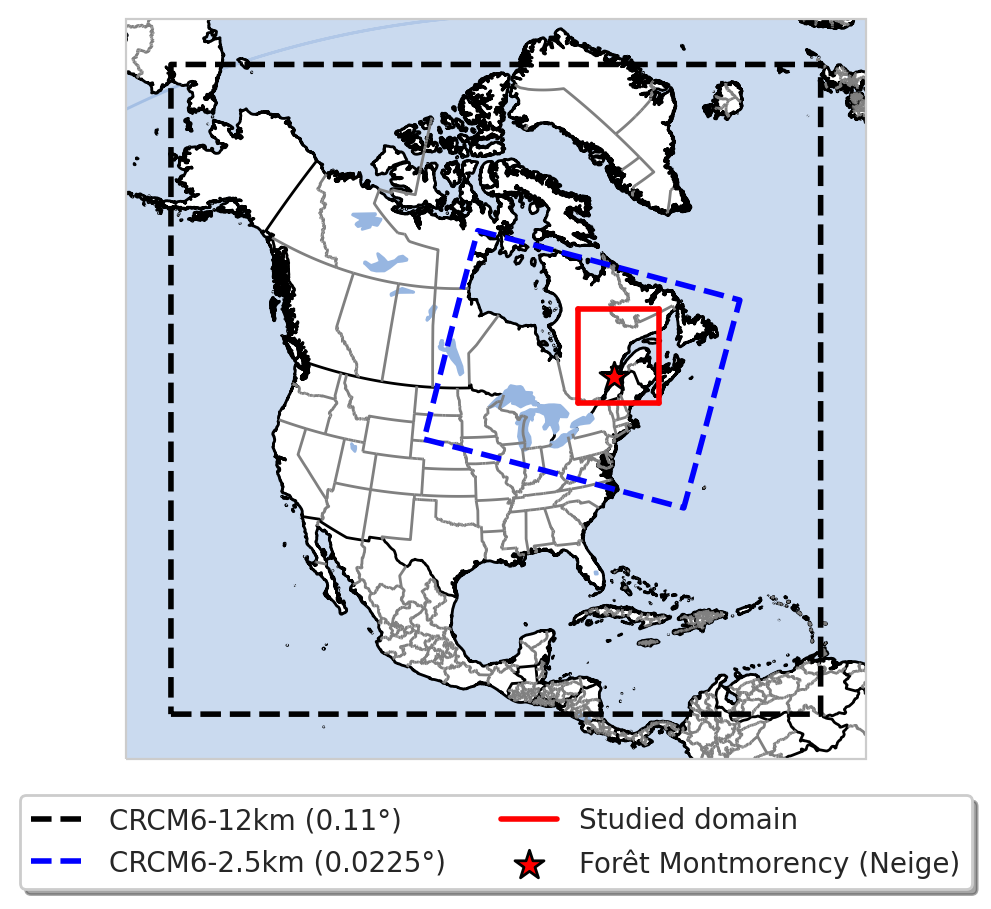

In [6]:

# Figure settings - if needed
# ---------------------------
# figsize = (5, 4.4)      # Figure size
fig = plt.figure(dpi=200)
# figsize=figsize
# Set projection defined by the cartopy object
ax = plt.axes(projection=m)

# Plotting - if needed
# --------------------

# Set corners of the maps
xll, yll = m.transform_point(lon_12km[ 0,  0],lat_12km[ 0,  0], ccrs.PlateCarree())
xur, yur = m.transform_point(lon_12km[-1, -1],lat_12km[-1, -1], ccrs.PlateCarree())


xllE2p5, yllE2p5 = m.transform_point(lonE2p5[ 0,  0],latE2p5[ 0,  0], ccrs.PlateCarree())
xurE2p5, yurE2p5 = m.transform_point(lonE2p5[-1, -1],latE2p5[-1, -1], ccrs.PlateCarree())


# Set geographic features
ax.add_feature(cfeature.OCEAN.with_scale('50m'),alpha=0.5)      # couche ocean
ax.add_feature(cfeature.LAND.with_scale('50m'),facecolor='none')       # couche land
#ax.add_feature(cfeature.LAKES.with_scale('50m'))      # couche lac
ax.add_feature(cfeature.BORDERS.with_scale('50m'))    # couche frontieres
#ax.add_feature(cfeature.RIVERS.with_scale('50m'))     # couche rivières
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',facecolor='none', name='coastline') # Couche côtières
ax.add_feature(coast, edgecolor='black')
ax.add_feature(cfeature.LAKES)
states_provinces = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',scale='10m',facecolor='none') # Couche provinces
ax.add_feature(states_provinces, edgecolor='grey')

ax.set_extent([xll-5, xur+5, yll-5, yur+5], crs=m)
# ax.set_extent([xll+15, xur-15, yll+15, yur-15], crs=m)
# To help the layout of the figure after saving
# fig.canvas.draw()
plt.tight_layout()  # To help with the layout of the figure after saving

# plot station


#Plot domains
# plt.plot(xm,ym,'ro')
plt.plot(rect12kmx,rect12kmy,'k--',lw=2, zorder=99999999, label='CRCM6-12km (0.11\u00b0)',)
plt.plot(rectE2p5x,rectE2p5y,'b--',lw=2, zorder=99999999, label='CRCM6-2.5km (0.0225\u00b0)')

# plot domain to study
print('Lower left',ccrs.PlateCarree().transform_point(xllE2p5 +17,yllE2p5 + 4, m))
print('Upper right',ccrs.PlateCarree().transform_point(xurE2p5 -9,yurE2p5 - 1, m))
# print([xllE2p5 +17,xllE2p5 +17],[ yllE2p5 + 4,yurE2p5 - 1])
plt.plot([xllE2p5 +17,xllE2p5 +17],[ yllE2p5 + 4,yurE2p5 - 1],lw=2,c='r', zorder=99999999,label='Studied domain')
plt.plot([xllE2p5 +17,xurE2p5 - 9],[ yllE2p5 + 4,yllE2p5 + 4],lw=2,c='r', zorder=99999999)
plt.plot([xllE2p5 +17,xurE2p5 - 9],[ yurE2p5 - 1,yurE2p5 - 1],lw=2,c='r', zorder=99999999)
plt.plot([xurE2p5 - 9,xurE2p5 - 9],[ yllE2p5 + 4,yurE2p5 - 1],lw=2,c='r', zorder=99999999)

# ax.set_extent([xll + 17, xur - 9, yll + 4, yur - 1], crs=m)
point_momo = ax.scatter(lon_momo, lat_momo, facecolor='red', s=120,marker="*", label='Forêt Montmorency (Neige)', zorder=9999,
                        edgecolors='k', transform=ccrs.PlateCarree())
# point_sondage = ax.scatter(lon_sond, lat_sond, facecolor='red', s=20, label='Radiosondage', zorder=9999, edgecolors='k',
#                            transform=ccrs.PlateCarree())
# point_uqam = ax.scatter(list_stat_lon, list_stat_lat, facecolor='orange', s=25, label='Climat sentinel station',
#                         zorder=9999, edgecolors='k', transform=ccrs.PlateCarree())

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.03),
          fancybox=True, shadow=True, ncol=2)
plt.show()
# Save figure
fig.savefig(image_output_file+'/domain_map_NorthAm.png', dpi=image_output_dpi, format='png', bbox_inches='tight') # Most backends
# fig.savefig(image_output_file+'/nothing_map_NorthAm.png', dpi=image_output_dpi, format='png', bbox_inches='tight') # Most backends
# support png, pdf, ps, eps and svg
#os.system ('convert python.png ' + image_output_file)         # Convert python.png to 'image_output_file', i.e. .gif


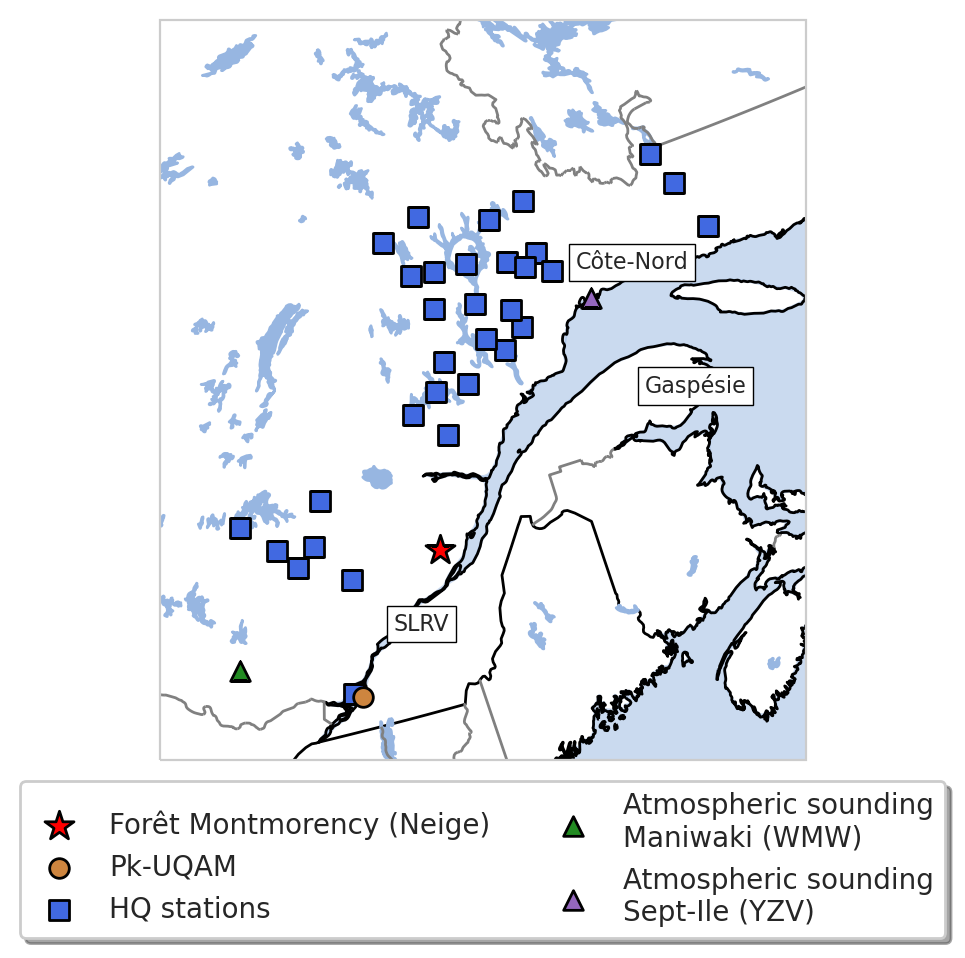

In [7]:


# figsize = (5, 4.4)      # Figure size
fig = plt.figure(dpi=200)
# figsize=figsize
# Set projection defined by the cartopy object
ax = plt.axes(projection=ccrs.LambertConformal())

# Plotting - if needed
# --------------------

# Set corners of the maps
xll, yll = m.transform_point(lonE2p5[ 0,  0],latE2p5[ 0,  0], ccrs.PlateCarree())
xur, yur = m.transform_point(lonE2p5[-1, -1],latE2p5[-1, -1], ccrs.PlateCarree())

xm, ym   = m.transform_point(-73.6053330201976,45.52028815987258, ccrs.PlateCarree(),)



# Set geographic features
ax.add_feature(cfeature.OCEAN.with_scale('50m'),alpha=0.5)      # couche ocean
ax.add_feature(cfeature.LAND.with_scale('50m'),facecolor='none')       # couche land
#ax.add_feature(cfeature.LAKES.with_scale('50m'))      # couche lac
ax.add_feature(cfeature.BORDERS.with_scale('50m'))    # couche frontieres
#ax.add_feature(cfeature.RIVERS.with_scale('50m'))     # couche rivières
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',facecolor='none', name='coastline') # Couche côtières
ax.add_feature(coast, edgecolor='black')
ax.add_feature(cfeature.LAKES)
states_provinces = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',scale='10m',facecolor='none') # Couche provinces
ax.add_feature(states_provinces, edgecolor='grey')

ax.set_extent([xll+17, xur-9, yll+4, yur-1], crs=m)
# print([xll+17, xur-9, yll+4, yur-1])

# To help the layout of the figure after saving
# fig.canvas.draw()
plt.tight_layout()  # To help with the layout of the figure after saving

# plot station
# idx_del = df_disdro[df_disdro['Name'] == 'LAVAL'].index[0]
# df_disdro.drop(index=idx_del,inplace=True)



point_momo = ax.scatter(lon_momo, lat_momo, facecolor='red', s=120, marker="*",label='Forêt Montmorency (Neige)', zorder=9999,
                        edgecolors='k', transform=ccrs.PlateCarree())


point_sondage_1 = ax.scatter(lon_sond[0], lat_sond[0], facecolor='forestgreen', s=50, label='Atmospheric sounding\nManiwaki (WMW)', zorder=9999, edgecolors='k',
                           transform=ccrs.PlateCarree(),marker="^")

point_sondage_2 = ax.scatter(lon_sond[1], lat_sond[1], facecolor='tab:purple', s=50, label='Atmospheric sounding\nSept-Ile (YZV)', zorder=9999, edgecolors='k',
                           transform=ccrs.PlateCarree(),marker="^")
point_uqam = ax.scatter(list_stat_lon, list_stat_lat, facecolor='peru', s=50, label='Pk-UQAM',
                        zorder=999999, edgecolors='k', transform=ccrs.PlateCarree())
# point_disdro= ax.scatter(df_hq['XCoord'].values, df_hq['YCoord'].values, facecolor='grey',s=45, label='Disdrometers',
#                         zorder=99999, edgecolors='k', transform=ccrs.PlateCarree(),marker="^")

point_stat_hq = ax.scatter(df_disdro['X'].values, df_disdro['Y'].values, facecolor='royalblue',marker='s',s=55, label='HQ stations',
                        zorder=999, edgecolors='k', transform=ccrs.PlateCarree())


legend_handle=[point_momo,point_uqam,point_stat_hq,point_sondage_1,point_sondage_2]

ax.legend(handles=legend_handle,loc='upper center', bbox_to_anchor=(0.5, -0.01),
          fancybox=True, shadow=True, ncol=2,fontsize=10)
transform = ccrs.PlateCarree()._as_mpl_transform(ax)
bbox = dict(boxstyle="square",ec='k', fc="w",lw=0.5)


ax.annotate('Côte-Nord',(-66.37,50.7),bbox=bbox,xycoords=transform,fontsize=8)
ax.annotate('SLRV',( -72.58736357929828,46.34952239262671),bbox=bbox,xycoords=transform,fontsize=8)
ax.annotate('Gaspésie',( -65.79562289686704,48.64225064055238),bbox=bbox,xycoords=transform,fontsize=8)
# Save figure
plt.show()
fig.savefig(image_output_file+'/studied_domain_map.png', dpi=image_output_dpi, format='png', bbox_inches='tight') # Most backends support
# fig.savefig(image_output_file+'/studied_domain_map.eps', dpi=image_output_dpi, format='eps', bbox_inches='tight') # Most backends support
# png, pdf, ps, eps and svg
# os.system ('convert python.png ' + image_output_file)         # Convert python.png to 'image_output_file', i.e. .gif